In [1]:
!pip install pennylane

  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 1.3 MB/s eta 0:00:00a 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 1.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.2 MB/s eta 0:00:00a 0:00:01
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 2.0 MB/s eta 0:00:00a 0:00:01
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Using cached gast-0.6.0-py3-none-any.whl (21 kB)


In [3]:
!pip install torch

  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached MarkupSafe-3.0.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (4.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 38.2 MB/s eta 0:00:0000:0100:01
Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
Using cached MarkupSafe-3.0.2-cp313-cp313-macosx_11_0_arm64.whl (12 kB)


## Compare learning rate

In [4]:
import numpy as np
import torch
import pennylane as qml

# Force 64-bit precision everywhere
torch.set_default_dtype(torch.float64)

def train_and_evaluate(
    n_qubits: int,
    n_layers: int,
    train_size: int = 1000,
    test_size: int = 1000,
    epochs: int = 50,
    lr: float = 0.05,
    seed: int = 0,
):
    """
    Trains a quantum model (AngleEmbedding + StronglyEntanglingLayers) to learn
    f(x1,x2) = sin(exp(x1) + x2) on [0,0.5]^2 and tests on [0.5,1]^2.

    Returns:
        weights           : trained torch Parameter
        train_losses      : list of train MSE per epoch
        test_losses       : list of test  MSE per epoch
    """
    # reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)

    # 1) Data generation
    def make_data(n, low, high):
        return torch.rand(n, 2) * (high - low) + low

    train_x = make_data(train_size, 0.0, 0.5)
    test_x  = make_data(test_size,  0.5, 1.0)
    train_y = torch.sin(torch.exp(train_x[:, 0]) + train_x[:, 1])
    test_y  = torch.sin(torch.exp(test_x[:, 0])  + test_x[:, 1])

    # 2) Build device & QNode
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface="torch")
    def quantum_model(x, weights):
        qml.AngleEmbedding(x, wires=range(n_qubits))
        qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        return qml.expval(qml.PauliZ(0))

    # 3) Initialize weights
    weight_shape = qml.templates.StronglyEntanglingLayers.shape(n_layers, n_qubits)
    weights = torch.nn.Parameter(0.01 * torch.randn(*weight_shape), requires_grad=True)

    # 4) Optimizer & loss
    opt = torch.optim.Adam([weights], lr=lr)
    loss_fn = torch.nn.MSELoss()

    train_losses = []
    test_losses  = []

    # 5) Training loop
    for ep in range(1, epochs + 1):
        # train epoch
        total_l = 0.0
        for x_sample, y_true in zip(train_x, train_y):
            opt.zero_grad()
            y_pred = quantum_model(x_sample, weights)
            l = loss_fn(y_pred, y_true)
            l.backward()
            opt.step()
            total_l += l.item()
        train_loss =  total_l / train_size
        train_losses.append(total_l / train_size)

        # test eval
        with torch.no_grad():
            preds = torch.stack([quantum_model(x_, weights) for x_ in test_x])
            test_l = loss_fn(preds, test_y).item()
            test_losses.append(test_l)
        test_loss = test_l
        print(f"Epoch {ep:2d}  Train MSE {train_loss:.4f}  Test MSE {test_loss:.4f}")

    return weights, train_losses, test_losses



=== Training with learning rate: 0.01 ===
Epoch  1  Train MSE 0.0011  Test MSE 0.6260
Epoch  2  Train MSE 0.0011  Test MSE 0.6257
Epoch  3  Train MSE 0.0011  Test MSE 0.6249
Epoch  4  Train MSE 0.0011  Test MSE 0.6252
Epoch  5  Train MSE 0.0011  Test MSE 0.6260
Epoch  6  Train MSE 0.0011  Test MSE 0.6257
Epoch  7  Train MSE 0.0011  Test MSE 0.6234
Epoch  8  Train MSE 0.0011  Test MSE 0.6210
Epoch  9  Train MSE 0.0011  Test MSE 0.6166
Epoch 10  Train MSE 0.0011  Test MSE 0.6175
Epoch 11  Train MSE 0.0011  Test MSE 0.6073
Epoch 12  Train MSE 0.0011  Test MSE 0.6069
Epoch 13  Train MSE 0.0011  Test MSE 0.6043
Epoch 14  Train MSE 0.0011  Test MSE 0.5988
Epoch 15  Train MSE 0.0010  Test MSE 0.5866
Epoch 16  Train MSE 0.0010  Test MSE 0.5825
Epoch 17  Train MSE 0.0010  Test MSE 0.5789
Epoch 18  Train MSE 0.0010  Test MSE 0.5740
Epoch 19  Train MSE 0.0010  Test MSE 0.5657
Epoch 20  Train MSE 0.0010  Test MSE 0.5620
Epoch 21  Train MSE 0.0010  Test MSE 0.5498
Epoch 22  Train MSE 0.0010  Test 

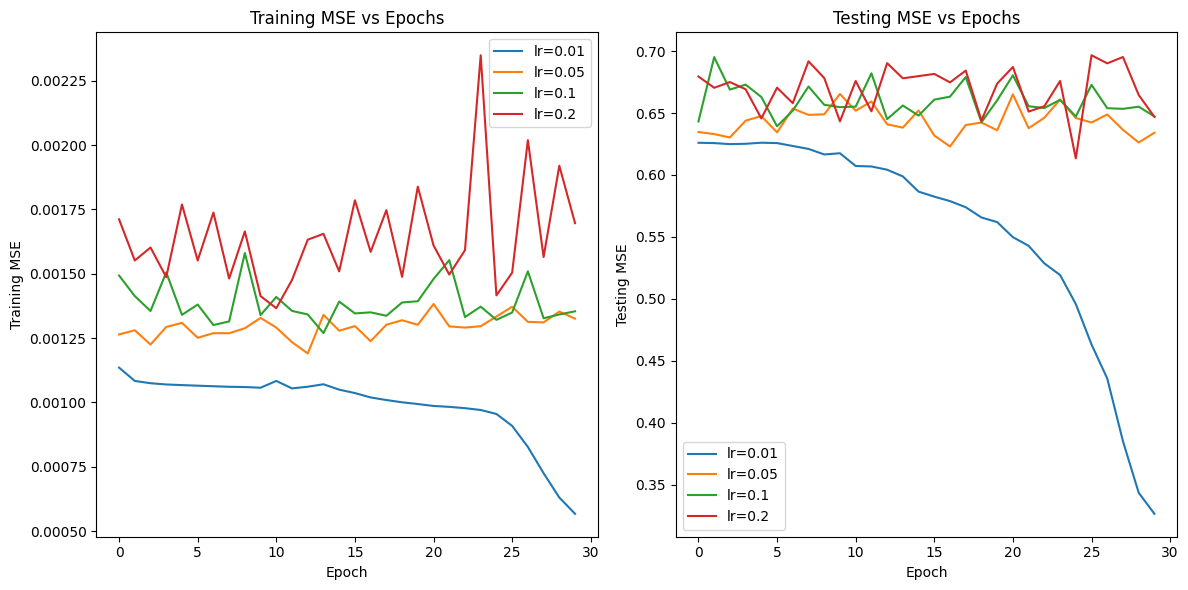

In [6]:
import matplotlib.pyplot as plt

# Define learning rates to test
learning_rates = [0.01, 0.05, 0.1, 0.2]

# Store results
results = {}

for lr in learning_rates:
    print(f"\n=== Training with learning rate: {lr} ===")
    _, train_losses, test_losses = train_and_evaluate(
        n_qubits=4,
        n_layers=3,
        train_size=200,
        test_size=200,
        epochs=30,
        lr=lr,
        seed=0
    )
    results[lr] = (train_losses, test_losses)

# Plotting
plt.figure(figsize=(12, 6))

# Plot training losses
plt.subplot(1, 2, 1)
for lr, (train_losses, _) in results.items():
    plt.plot(train_losses, label=f"lr={lr}")
plt.title("Training MSE vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Training MSE")
plt.legend()

# Plot testing losses
plt.subplot(1, 2, 2)
for lr, (_, test_losses) in results.items():
    plt.plot(test_losses, label=f"lr={lr}")
plt.title("Testing MSE vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Testing MSE")
plt.legend()

plt.tight_layout()
plt.show()


It seems like lr = 0.01 has the best generalization.

## Compare number of qubits


=== Training with 2 qubits ===
Epoch  1  Train MSE 0.0011  Test MSE 0.3597
Epoch  2  Train MSE 0.0008  Test MSE 0.3281
Epoch  3  Train MSE 0.0007  Test MSE 0.3033
Epoch  4  Train MSE 0.0006  Test MSE 0.2836
Epoch  5  Train MSE 0.0005  Test MSE 0.2745
Epoch  6  Train MSE 0.0005  Test MSE 0.2702
Epoch  7  Train MSE 0.0005  Test MSE 0.2666
Epoch  8  Train MSE 0.0005  Test MSE 0.2643
Epoch  9  Train MSE 0.0005  Test MSE 0.2634
Epoch 10  Train MSE 0.0004  Test MSE 0.2635
Epoch 11  Train MSE 0.0004  Test MSE 0.2643
Epoch 12  Train MSE 0.0004  Test MSE 0.2654
Epoch 13  Train MSE 0.0004  Test MSE 0.2666
Epoch 14  Train MSE 0.0004  Test MSE 0.2678
Epoch 15  Train MSE 0.0004  Test MSE 0.2690
Epoch 16  Train MSE 0.0004  Test MSE 0.2701
Epoch 17  Train MSE 0.0004  Test MSE 0.2712
Epoch 18  Train MSE 0.0004  Test MSE 0.2720
Epoch 19  Train MSE 0.0004  Test MSE 0.2726
Epoch 20  Train MSE 0.0004  Test MSE 0.2732
Epoch 21  Train MSE 0.0004  Test MSE 0.2735
Epoch 22  Train MSE 0.0004  Test MSE 0.2738


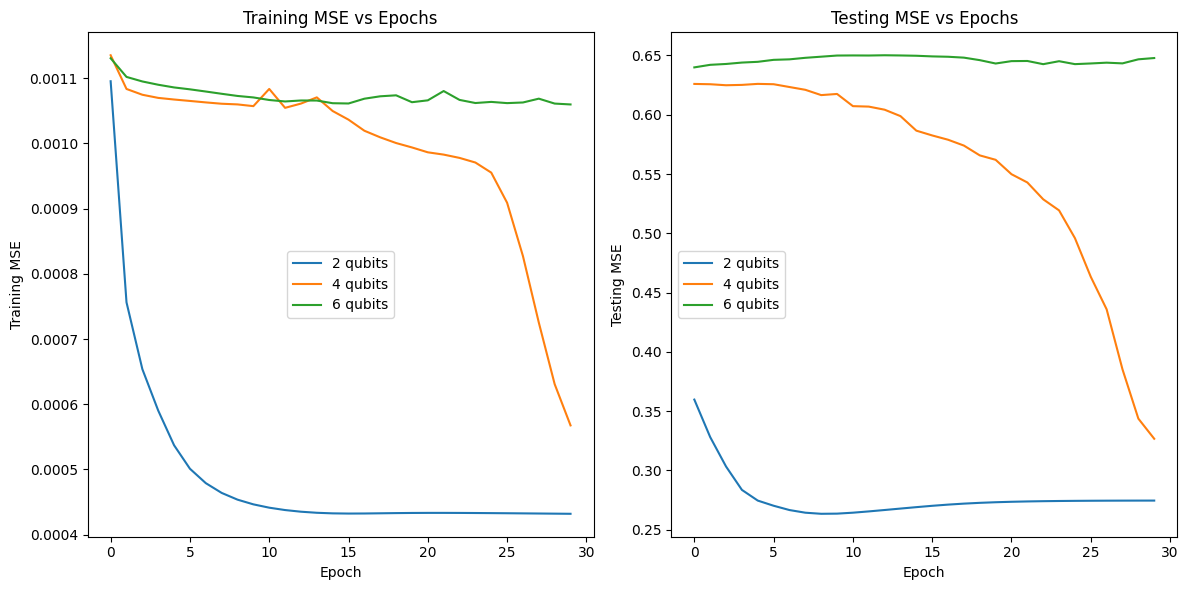

In [8]:
import matplotlib.pyplot as plt

# Define qubit counts to compare
qubit_counts = [2, 4, 6]

# Store results
results = {}

for n_qubits in qubit_counts:
    print(f"\n=== Training with {n_qubits} qubits ===")
    _, train_losses, test_losses = train_and_evaluate(
        n_qubits=n_qubits,
        n_layers=3,
        train_size=200,
        test_size=200,
        epochs=30,
        lr=0.01,
        seed=0
    )
    results[n_qubits] = (train_losses, test_losses)

# Plotting
plt.figure(figsize=(12, 6))

# Plot training losses
plt.subplot(1, 2, 1)
for n_qubits, (train_losses, _) in results.items():
    plt.plot(train_losses, label=f"{n_qubits} qubits")
plt.title("Training MSE vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Training MSE")
plt.legend()

# Plot testing losses
plt.subplot(1, 2, 2)
for n_qubits, (_, test_losses) in results.items():
    plt.plot(test_losses, label=f"{n_qubits} qubits")
plt.title("Testing MSE vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Testing MSE")
plt.legend()

plt.tight_layout()
plt.show()


It shows that 2 qubits will be a better choice.

## Compare n_layer


=== Training with 1 layers ===
Epoch  1  Train MSE 0.0015  Test MSE 0.4318
Epoch  2  Train MSE 0.0012  Test MSE 0.4414
Epoch  3  Train MSE 0.0012  Test MSE 0.4402
Epoch  4  Train MSE 0.0012  Test MSE 0.4420
Epoch  5  Train MSE 0.0012  Test MSE 0.4447
Epoch  6  Train MSE 0.0012  Test MSE 0.4433
Epoch  7  Train MSE 0.0012  Test MSE 0.4466
Epoch  8  Train MSE 0.0012  Test MSE 0.4439
Epoch  9  Train MSE 0.0012  Test MSE 0.4463
Epoch 10  Train MSE 0.0012  Test MSE 0.4478
Epoch 11  Train MSE 0.0012  Test MSE 0.4453
Epoch 12  Train MSE 0.0012  Test MSE 0.4450
Epoch 13  Train MSE 0.0012  Test MSE 0.4484
Epoch 14  Train MSE 0.0012  Test MSE 0.4463
Epoch 15  Train MSE 0.0012  Test MSE 0.4464
Epoch 16  Train MSE 0.0012  Test MSE 0.4459
Epoch 17  Train MSE 0.0012  Test MSE 0.4448
Epoch 18  Train MSE 0.0012  Test MSE 0.4450
Epoch 19  Train MSE 0.0012  Test MSE 0.4500
Epoch 20  Train MSE 0.0012  Test MSE 0.4448
Epoch 21  Train MSE 0.0012  Test MSE 0.4393
Epoch 22  Train MSE 0.0012  Test MSE 0.4497


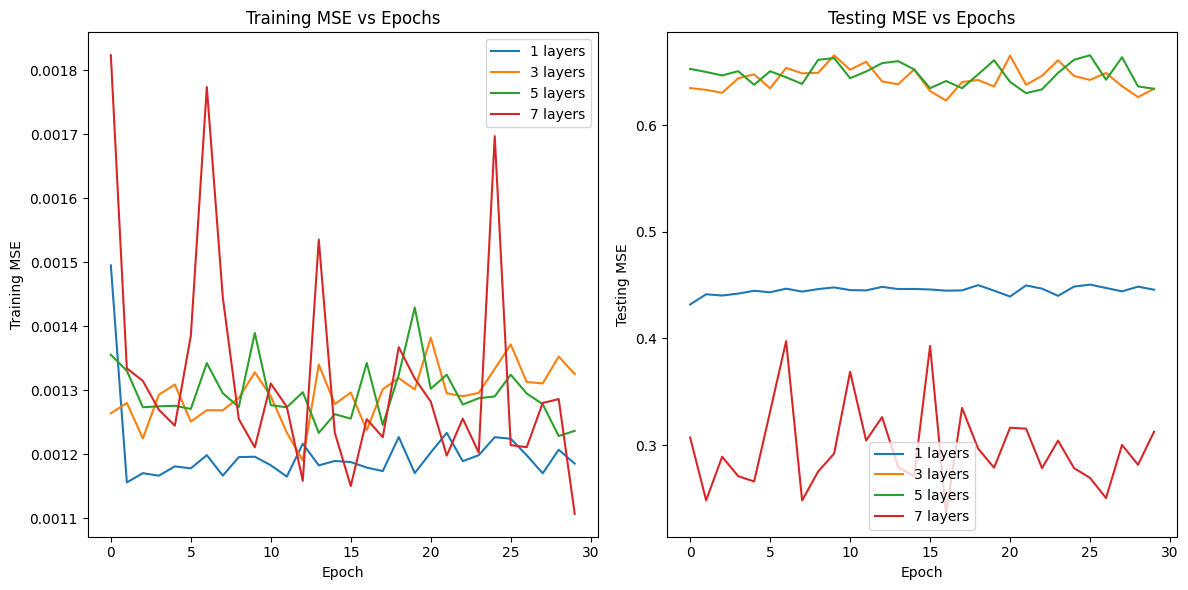

In [9]:
import matplotlib.pyplot as plt

# Define number of layers to compare
layer_counts = [1, 3, 5, 7]

# Store results
results = {}

for n_layers in layer_counts:
    print(f"\n=== Training with {n_layers} layers ===")
    _, train_losses, test_losses = train_and_evaluate(
        n_qubits=4,
        n_layers=n_layers,
        train_size=200,
        test_size=200,
        epochs=30,
        lr=0.05,
        seed=0
    )
    results[n_layers] = (train_losses, test_losses)

# Plotting
plt.figure(figsize=(12, 6))

# Plot training losses
plt.subplot(1, 2, 1)
for n_layers, (train_losses, _) in results.items():
    plt.plot(train_losses, label=f"{n_layers} layers")
plt.title("Training MSE vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Training MSE")
plt.legend()

# Plot testing losses
plt.subplot(1, 2, 2)
for n_layers, (_, test_losses) in results.items():
    plt.plot(test_losses, label=f"{n_layers} layers")
plt.title("Testing MSE vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Testing MSE")
plt.legend()

plt.tight_layout()
plt.show()


It shows that 7 layers has better generalization effect.

## Final Choice (7 layers, learning rate = 0.01, 2 qubits)

Epoch  1  Train MSE 0.0015  Test MSE 0.3352
Epoch  2  Train MSE 0.0014  Test MSE 0.4639
Epoch  3  Train MSE 0.0012  Test MSE 0.5568
Epoch  4  Train MSE 0.0018  Test MSE 0.4781
Epoch  5  Train MSE 0.0013  Test MSE 0.4732
Epoch  6  Train MSE 0.0013  Test MSE 0.3804
Epoch  7  Train MSE 0.0013  Test MSE 0.4360
Epoch  8  Train MSE 0.0012  Test MSE 0.4446
Epoch  9  Train MSE 0.0012  Test MSE 0.4528
Epoch 10  Train MSE 0.0013  Test MSE 0.4680
Epoch 11  Train MSE 0.0013  Test MSE 0.4218
Epoch 12  Train MSE 0.0012  Test MSE 0.5974
Epoch 13  Train MSE 0.0021  Test MSE 0.5821
Epoch 14  Train MSE 0.0013  Test MSE 0.4302
Epoch 15  Train MSE 0.0011  Test MSE 0.4040
Epoch 16  Train MSE 0.0012  Test MSE 0.5217
Epoch 17  Train MSE 0.0018  Test MSE 0.6094
Epoch 18  Train MSE 0.0016  Test MSE 0.4024
Epoch 19  Train MSE 0.0013  Test MSE 0.4068
Epoch 20  Train MSE 0.0011  Test MSE 0.5480
Epoch 21  Train MSE 0.0015  Test MSE 0.5160
Epoch 22  Train MSE 0.0012  Test MSE 0.5030
Epoch 23  Train MSE 0.0011  Test

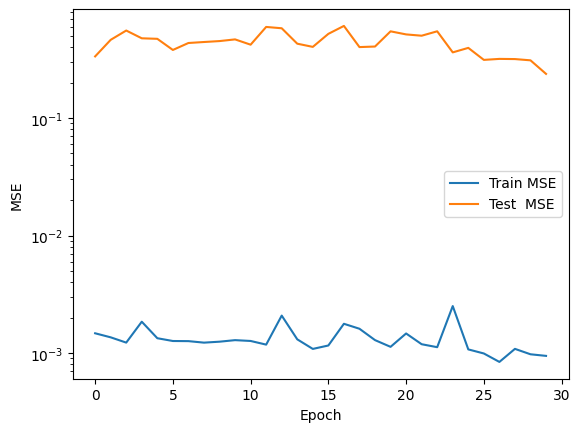

In [10]:
# Train a 2-qubit, 4-layer model:
weights, train_hist, test_hist = train_and_evaluate(n_qubits=2, n_layers=7,train_size = 200,test_size = 200,epochs=30,
        lr=0.05)

# Plot learning curves:
import matplotlib.pyplot as plt
plt.plot(train_hist, label="Train MSE")
plt.plot(test_hist,  label="Test  MSE")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()